PD is the most volatile component of expected loss. Creation of a PD model is the most cumbersome part of the credit risk Modelling. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

## Import Data

In [2]:
# using the previously preprocessed data for developing the LGD and EAd models
loan_data_preprocessed_backup = pd.concat([pd.read_csv('loan_data_inputs_train.csv'), 
                                           pd.read_csv('loan_data_inputs_test.csv')], sort = False)

In [3]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [4]:
loan_data_preprocessed.shape

(466285, 325)

In [5]:
loan_data_preprocessed = loan_data_preprocessed.set_index('Unnamed: 0')

To build LGD models, we need to see the percentage of exposure that was lost after the borrower defaulted. To build EAD Models, we need to know the amount of exposure at the time the borrower defaulted. This data exists and can only be seen for the accounts that defaulted. There is also a need to account for the amount that would be recovered AFTER the borrower has defaulted. Thus, when building LGD and EAD Models, it is good practice to build models with data from borrowers that have had enough time to repay part of the remaining debt. 

In [6]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off', 
                                                                   'Does not meet the credit policy. Status:Charged Off'])]

In [7]:
loan_data_defaults.shape

(43236, 324)

In [8]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Explore Data

### Independent Variables

The independent variables we use for LGD and EAD models we build rely on the same independent variables as in the PD model. The PD model ultimately used fewer variables- so we need to check the variables to see if they have any missing values. 

In [9]:
loan_data_defaults.isnull().sum()

Unnamed: 0.1                                                           0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                                          2337
home_ownership                                     

There are missing values in some variables - some of them were fixed. Two variables which we will be using later still have missing values. mths_since_last_delinq & mths_since_last_record are these variables. In the PD Model we could use the dummy variables. The independent variables in LGD/ EAD need not be dummies. In this case, we can impute the missing values to be 0. This would be the most conservative approach to risk. 

In [10]:
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace = True)

C:\Users\DevanshiKulshreshtha\AppData\Local\Programs\Python\Python37\Lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Dependent Variables

#### Loss Given Default (LGD Model)

Loss given default is the share of an asset that is lost if a borrower defaults. % of exposure that is not recovered by the lender if a default has occurred. The established approach in practice is to model for the total % of exposure that can be recovered by the lender once a default has occured. This proportion is called recovery rate. Loss given default is 1- recovery rate.   

In our data the column funded amount reflects the amount lost when the borrower defaults. 

In [11]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries']/loan_data_defaults['funded_amnt']

C:\Users\DevanshiKulshreshtha\AppData\Local\Programs\Python\Python37\Lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

The minimum recovery rate is 0, as expected. The maximum recovery rate is greater than 1. This rate should have been bound between 0 and 1. In this case, we can truncate the values to lie between 0 & 1. 

In [13]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

C:\Users\DevanshiKulshreshtha\AppData\Local\Programs\Python\Python37\Lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\DevanshiKulshreshtha\AppData\Local\Programs\Python\Python37\Lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

#### Exposure at Default (EAD Model)

Exposure at default is the total value that the lender is exposed to when a borrower defaults. It is the maximum a bank may lose when a borrower defaults on a loan. The borrower may have only defaulted on a proportion of the total funded amount. This is because not all the amount is transferred to the borrower in one-go. It is also possible that the borrower has repaid some amount, or has a varying credit limit in case of credit cards. The exposure at default then is measured by the product of total funded amount and the credit conversion factor.

In [15]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])/loan_data_defaults['funded_amnt']

C:\Users\DevanshiKulshreshtha\AppData\Local\Programs\Python\Python37\Lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


If all was paid, CCf would be 0. If nothing was paid, CCF would be 1. 

In [16]:
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

## Saving the data

In [17]:
loan_data_defaults.to_csv('loan_data_defaults.csv')

## Explore dependent variables

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Loss Given Default

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

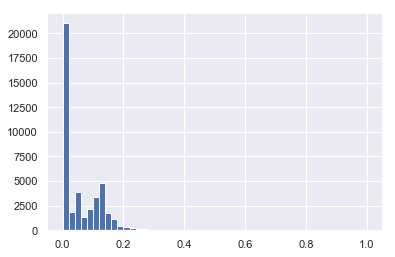

In [19]:
plt.hist(loan_data_defaults['recovery_rate'], bins=50)

Methodically speaking, the density of proportions is described as a specific distribution called beta distribution. The regression model used to assess the impact of a set of dependent variables on a variable with beta distribution is called beta regression. It is used to model outcomes that are strictly greater than 0 and strictly lower than 1. Some alteration would also allow to model for cases lower than or equal to 0, and cases greater than or equal to 1. No current python functionality does beta regression. There is a R library for this, however. But conversion of Python objects to R objects is computationally heavy and requires a lot of RAM. 

Alternatively, this can be achieved using logistic or linear regression. 

Modelling LGD is a two-step approach. 
 - Is LGD greater than 0 or not? (This is solved using a logistic regression)
 - IF recovery rate is greater than 0, how much is it exactly? (linear regression is used for this part.)
 

In [20]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

C:\Users\DevanshiKulshreshtha\AppData\Local\Programs\Python\Python37\Lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Exposure at Default (EAD)

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

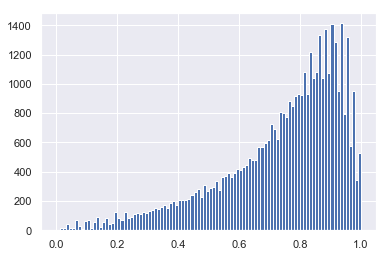

In [21]:
plt.hist(loan_data_defaults['CCF'], bins=100)

Credit Cinversion Factor is more homogeneously distributed. Here, direct application of linear regression model would produce satisfactory results. 

## LGD Model 

### Splitting the data

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['recovery_rate', 'recovery_rate_0_1'], axis=1), loan_data_defaults['recovery_rate_0_1'], test_size=0.2, random_state=42)

### Preparing the inputs

In [24]:
features_all = ['grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    'home_ownership:MORTGAGE',
    'home_ownership:NONE',
    'home_ownership:OTHER',
    'home_ownership:OWN',
    'home_ownership:RENT',
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    'purpose:car',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:educational',
    'purpose:home_improvement',
    'purpose:house',
    'purpose:major_purchase',
    'purpose:medical',
    'purpose:moving',
    'purpose:other',
    'purpose:renewable_energy',
    'purpose:small_business',
    'purpose:vacation',
    'purpose:wedding',
    'initial_list_status:f',
    'initial_list_status:w',
    'term_int',
    'emp_length_int',
    'mths_since_issue_d',
    'mths_since_earliest_cr_line',
    'funded_amnt',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'mths_since_last_record',
    'open_acc',
    'pub_rec',
    'total_acc',
    'acc_now_delinq',
    'total_rev_hi_lim']

In [25]:
 features_reference_cat = ['grade:G',
    'home_ownership:RENT',
    'verification_status:Verified',
    'purpose:credit_card',
    'initial_list_status:f']

In [26]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]

In [27]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

### Estimating the Model

In [28]:
from sklearn import linear_model
import scipy.stats as stat
    
class LogisticRegression_with_p_values:
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)
    
    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [29]:
reg_lgd_stg_1 = LogisticRegression_with_p_values()
reg_lgd_stg_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

C:\Users\DevanshiKulshreshtha\AppData\Local\Programs\Python\Python37\Lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [30]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [31]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_stg_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_stg_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_stg_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-7.801488e-05,NaN
1,grade:A,-1.602071e-05,9.998482e-01
2,grade:B,-5.767702e-05,9.993210e-01
3,grade:C,-1.048200e-04,9.987177e-01
4,grade:D,7.120937e-06,9.999162e-01
5,grade:E,2.523004e-05,9.997306e-01
6,grade:F,5.949107e-05,9.994493e-01
7,home_ownership:MORTGAGE,-3.652066e-05,9.988511e-01
8,home_ownership:NONE,1.046474e-06,9.999991e-01
9,home_ownership:OTHER,8.530442e-07,9.999984e-01


Most of the p-values are insiginificant. This is also fairly different from the PD model because continuous variables contribute differently here. 

### Testing the Data

In [32]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [33]:
y_hat_test_lgd_stage_1 = reg_lgd_stg_1.model.predict(lgd_inputs_stage_1_test)

In [34]:
y_hat_test_lgd_stage_1

array([0, 1, 1, ..., 1, 1, 1])

In [35]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_stg_1.model.predict_proba(lgd_inputs_stage_1_test)

In [36]:
y_hat_test_proba_lgd_stage_1

array([[0.50085939, 0.49914061],
       [0.43009479, 0.56990521],
       [0.40632862, 0.59367138],
       ...,
       [0.42237561, 0.57762439],
       [0.36758299, 0.63241701],
       [0.39032667, 0.60967333]])

In [37]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[:][:, 1]
y_hat_test_proba_lgd_stage_1

array([0.49914061, 0.56990521, 0.59367138, ..., 0.57762439, 0.63241701,
       0.60967333])

In [38]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [39]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [40]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)

In [41]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [42]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [43]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
Unnamed: 0,,
273771,1,0.499141
353045,0,0.569905
437319,0,0.593671
193344,1,0.620934
173478,0,0.654531


### Estimating the Аccuracy of the Мodel

In [44]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [45]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,830,2988
1,569,4261


In [46]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.095976,0.345513
1,0.065796,0.492715


In [47]:
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.588691026827012

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

In [49]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

Text(0.5, 1.0, 'ROC curve')

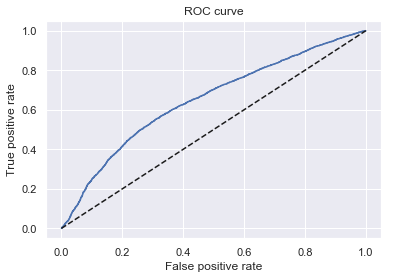

In [50]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [51]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6493181475564694

This model will feed into a larger part of LGD model. It is more important to have a large proportion of correctly classified values than to have correctly classified 0s.

### Saving the Model

In [52]:
import pickle

In [53]:
pickle.dump(reg_lgd_stg_1, open('lgd_model_stage_1.sav', 'wb'))

### Stage 2 – Linear Regression

In [54]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [55]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [56]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
import scipy.stats as stat

In [58]:
 class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True, n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [59]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [60]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [61]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [63]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.596938e-01,NaN
1,grade:A,-8.542690e-02,0.000
2,grade:B,-6.188003e-02,0.000
3,grade:C,-4.839458e-02,0.000
4,grade:D,-3.485955e-02,0.000
5,grade:E,-1.903750e-02,0.000
6,grade:F,-1.049819e-02,0.029
7,home_ownership:MORTGAGE,2.436485e-03,0.101
8,home_ownership:NONE,1.435097e-01,0.000
9,home_ownership:OTHER,5.398035e-02,0.007


### Stage 2 – Linear Regression Evaluation

In [64]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

In [65]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [66]:
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [67]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [68]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [69]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [70]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.286862
0,0.286862,1.000000


The correlation between actual and predicted values is about 0.28. Next, we look at the residuals:

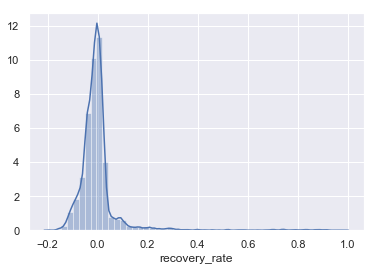

In [71]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

The residuals are normally distributed. Most of teh residuals are around 0. 

In [72]:
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

### Combining Stage 1 and Stage 2

In [73]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [74]:
y_hat_test_lgd_stage_2_all

array([0.16635956, 0.12970321, 0.11178222, ..., 0.13482438, 0.10030033,
       0.1022201 ])

Multiplying the stage 1 output by stage 2 predictions.

In [75]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [76]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.091575
std,0.048131
min,-0.004605
25%,0.072571
50%,0.104502
75%,0.125289
max,0.240398


Bounding the values between 0 & 1:

In [77]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [78]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.091576
std,0.048129
min,0.000000
25%,0.072571
50%,0.104502
75%,0.125289
max,0.240398


## LGD Model 

### Estimation and Interpretation

In [79]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [80]:
ead_inputs_train.columns.values

array(['Unnamed: 0.1', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       've

In [81]:
ead_inputs_train = ead_inputs_train[features_all]

In [82]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

In [83]:
reg_ead = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
feature_name = ead_inputs_train.columns.values

In [85]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1    
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values

In [86]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.093094e+00,NaN
1,grade:A,-2.894310e-01,0.000000e+00
2,grade:B,-2.244252e-01,0.000000e+00
3,grade:C,-1.633800e-01,0.000000e+00
4,grade:D,-1.130634e-01,0.000000e+00
5,grade:E,-6.468890e-02,0.000000e+00
6,grade:F,-1.992665e-02,4.854031e-03
7,home_ownership:MORTGAGE,-6.690328e-03,1.413242e-03
8,home_ownership:NONE,2.394354e-02,7.535378e-01
9,home_ownership:OTHER,2.131938e-04,9.945523e-01


Positive coefficients denote an increase in the credit conversion factor. Higher credit conversion factor implies that greater amount of principal will be lost when the borrower defaults.   

### Model Validation

In [87]:
ead_inputs_test = ead_inputs_test[features_all]

In [88]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [89]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [90]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [91]:
ead_targets_test_temp = ead_targets_test

In [92]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [93]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.519025
0,0.519025,1.000000


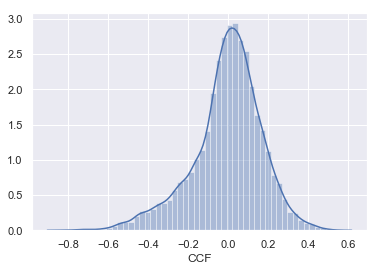

In [94]:
sns.distplot(ead_targets_test - y_hat_test_ead)

In [95]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736496
std,0.104488
min,0.385728
25%,0.663043
50%,0.732533
75%,0.810754
max,1.008398


In [96]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [97]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736495
std,0.104485
min,0.385728
25%,0.663043
50%,0.732533
75%,0.810754
max,1.000000


# Expected Loss

In [98]:
loan_data_preprocessed.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mths_since_earliest_cr_line,issue_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_ANY_NONE,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_factor,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate_factor,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,funded_amnt_factor,mths_sinc

In [99]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [100]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

In [101]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [102]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_stg_1.model.predict(loan_data_preprocessed_lgd_ead)

In [103]:
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [104]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [105]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [106]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

In [107]:
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.912730
std           0.055654
min           0.321264
25%           0.870123
50%           0.893023
75%           0.968457
max           1.000000
Name: LGD, dtype: float64

In [108]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [109]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [110]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

In [111]:
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10799.270671
std        6911.776212
min         188.608082
25%        5498.705108
50%        9206.234398
75%       14664.679124
max       35000.000000
Name: EAD, dtype: float64

In [112]:
features_all_pd = ['grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    'home_ownership:RENT_OTHER_ANY_NONE',
    'home_ownership:OWN',
    'home_ownership:MORTGAGE',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'addr_state:NM_VA',
    'addr_state:NY',
    'addr_state:OK_TN_MO_LA_MD_NC',
    'addr_state:CA',
    'addr_state:UT_KY_AZ_NJ',
    'addr_state:AR_MI_PA_OH_MN',
    'addr_state:RI_MA_DE_SD_IN',
    'addr_state:GA_WA_OR',
    'addr_state:WI_MT',
    'addr_state:TX',
    'addr_state:IL_CT',
    'addr_state:KS_SC_CO_VT_AK_MS',
    'addr_state:WV_NH_WY_DC_ME_ID',
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    'purpose:educ__sm_b__wedd__ren_en__mov__house',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:oth__med__vacation',
    'purpose:major_purch__car__home_impr',
    'initial_list_status:f',
    'initial_list_status:w',
    'term:36',
    'term:60',
    'emp_length:0',
    'emp_length:1',
    'emp_length:2-4',
    'emp_length:5-6',
    'emp_length:7-9',
    'emp_length:10',
    'mths_since_issue_d:<38',
    'mths_since_issue_d:38-39',
    'mths_since_issue_d:40-41',
    'mths_since_issue_d:42-48',
    'mths_since_issue_d:49-52',
    'mths_since_issue_d:53-64',
    'mths_since_issue_d:65-84',
    'mths_since_issue_d:>84',
    'int_rate:<9.548',
    'int_rate:9.548-12.025',
    'int_rate:12.025-15.74',
    'int_rate:15.74-20.281',
    'int_rate:>20.281',
    'mths_since_earliest_cr_line:<140',
    'mths_since_earliest_cr_line:141-164',
    'mths_since_earliest_cr_line:165-247',
    'mths_since_earliest_cr_line:248-270',
    'mths_since_earliest_cr_line:271-352',
    'mths_since_earliest_cr_line:>352',
    'inq_last_6mths:0',
    'inq_last_6mths:1-2',
    'inq_last_6mths:3-6',
    'inq_last_6mths:>6',
    'acc_now_delinq:0',
    'acc_now_delinq:>=1',
    'annual_inc:<20K',
    'annual_inc:20K-30K',
    'annual_inc:30K-40K',
    'annual_inc:40K-50K',
    'annual_inc:50K-60K',
    'annual_inc:60K-70K',
    'annual_inc:70K-80K',
    'annual_inc:80K-90K',
    'annual_inc:90K-100K',
    'annual_inc:100K-120K',
    'annual_inc:120K-140K',
    'annual_inc:>140K',
    'dti:<=1.4',
    'dti:1.4-3.5',
    'dti:3.5-7.7',
    'dti:7.7-10.5',
    'dti:10.5-16.1',
    'dti:16.1-20.3',
    'dti:20.3-21.7',
    'dti:21.7-22.4',
    'dti:22.4-35',
    'dti:>35',
    'mths_since_last_delinq:Missing',
    'mths_since_last_delinq:0-3',
    'mths_since_last_delinq:4-30',
    'mths_since_last_delinq:31-56',
    'mths_since_last_delinq:>=57',
    'mths_since_last_record:Missing',
    'mths_since_last_record:0-2',
    'mths_since_last_record:3-20',
    'mths_since_last_record:21-31',
    'mths_since_last_record:32-80',
    'mths_since_last_record:81-86',
    'mths_since_last_record:>86']

In [113]:
ref_categories_pd = ['grade:G',
    'home_ownership:RENT_OTHER_ANY_NONE',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'verification_status:Verified',
    'purpose:educ__sm_b__wedd__ren_en__mov__house',
    'initial_list_status:f',
    'term:60',
    'emp_length:0',
    'mths_since_issue_d:>84',
    'int_rate:>20.281',
    'mths_since_earliest_cr_line:<140',
    'inq_last_6mths:>6',
    'acc_now_delinq:0',
    'annual_inc:<20K',
    'dti:>35',
    'mths_since_last_delinq:0-3',
    'mths_since_last_record:0-2']

In [114]:
loan_data_inputs_pd_temp = loan_data_preprocessed[features_all_pd]

In [115]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [116]:
reg_pd = pickle.load(open('pd_model.sav', 'rb'))

In [117]:
loan_data_inputs_pd_temp['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

In [119]:
loan_data_inputs_pd_temp['PD'].head()

Unnamed: 0
427211    0.029846
206088    0.091919
136020    0.037337
412305    0.203772
36159     0.201658
Name: PD, dtype: float64

In [120]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd_temp], axis = 1)

In [121]:
loan_data_preprocessed_new.shape

(466285, 415)

In [122]:
loan_data_preprocessed_new.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mths_since_earliest_cr_line,issue_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_ANY_NONE,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_factor,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate_factor,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,funded_amnt_factor,mths_sinc

In [123]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [124]:
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean       1069.999509
std        1089.294869
min           9.531043
25%         351.111789
50%         699.797917
75%        1387.576841
max       11940.773612
Name: EL, dtype: float64

Expected loss per loan is 1069 dollars.

In [125]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,PD,LGD,EAD,EL
Unnamed: 0,,,,,
427211,24000,0.029846,1.000000,16099.631139,480.507201
206088,10000,0.091919,0.897942,6543.403876,540.080738
136020,20425,0.037337,0.907300,12536.398927,424.678560
412305,17200,0.203772,0.880074,13709.242296,2458.543635
36159,8400,0.201658,0.891740,5091.443547,915.577854


In [126]:
loan_data_preprocessed_new['funded_amnt'].describe()

count    466285.000000
mean      14291.801044
std        8274.371300
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64

In [127]:
loan_data_preprocessed_new['EL'].sum()

498924720.8855915

In [128]:
loan_data_preprocessed_new['funded_amnt'].sum()

6664052450

In [129]:
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

0.07486806633486078

The expected loss the bank would make is around 7.48%. A bank usually holds 10% of its assets as capital. A value lower than 10% is preferred. This proportion can help the bank decide whether to be more aggressive or conservative in the future. 